# Aprendizagem Automática Avançada
## Project
### Luís Ferreirinha Nº51227
### Christopher Anaya Nº60566

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

We start by downloading the Draper dataset from: https://osf.io/d45bw/

This is the dataset we will be analysing in this project, containing over a 1 milion C/C++ function definitions.

In [2]:
train_dataset = h5py.File('../../Dataset/VDISC_train.hdf5')
validation_dataset = h5py.File('../../Dataset/VDISC_validate.hdf5')
test_dataset = h5py.File('../../Dataset/VDISC_test.hdf5')

Now we will convert these datasets to Pandas

In [3]:
def convert_to_pandas(dataset):
    data_frame = {
        'code': dataset['functionSource'],
        'CWE-119': dataset['CWE-119'],
        'CWE-120': dataset['CWE-120'],
        'CWE-469': dataset['CWE-469'],
        'CWE-476': dataset['CWE-476'],
        'CWE-OTHERS': dataset['CWE-other'],
    }

    return pd.DataFrame(data=data_frame)

train_pd = convert_to_pandas(train_dataset)
validation_pd = convert_to_pandas(validation_dataset)
test_pd = convert_to_pandas(test_dataset)

We can now take a look at the dataset

In [4]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,b'visitICmpInst(ICmpInst &I) {\n // We must c...,False,False,False,False,False
1019467,b'path_node_delete_chain(path_node * head)\n{\...,False,False,False,False,False
1019468,b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...,False,False,False,False,False
1019469,"b'Next(const SQObjectPtr &refpos, SQObjectPtr ...",False,False,False,False,False


As we can see this dataset is composed of function definition which are classified according to 5 vulnerability categories.  

For preprocessing and vector embedding processes we will have to join the three datasets. These will later be split before training the models.

In [5]:
dataset_joined = pd.concat([train_pd, validation_pd, test_pd], ignore_index=True)

## Per-Vulnerability Datasets

Since our goal is to train classifiers for each type of vulnerability present here, we will have to split the dataset into 5 ones, one for each vulnerability.

#### CWE-120

In [6]:
cols_to_drop = ["CWE-119", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_120_df = dataset_joined.drop(cols_to_drop, axis=1)

#### CWE-119

In [7]:
cols_to_drop = ["CWE-120", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_119_df = dataset_joined.drop(cols_to_drop, axis=1)

#### CWE-469

In [8]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-476", "CWE-OTHERS"]
CWE_469_df = dataset_joined.drop(cols_to_drop, axis=1)

#### CWE-476

In [9]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-OTHERS"]
CWE_476_df = dataset_joined.drop(cols_to_drop, axis=1)

#### CWE-OTHERS

In [10]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-476"]
CWE_OTHERS_df = dataset_joined.drop(cols_to_drop, axis=1)

### Unbalanced classes

The dataset we're using contains a great imbalance in the classes

In [21]:
def plot_classes(dataset, vulnerability):
    shuffled_df = dataset.sample(frac=1,random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability] == False]
    non_normalized_df = pd.concat([vul_df, non_vul_df])
    plt.figure(figsize=(8, 8))
    sns.countplot(x=vulnerability, data=non_normalized_df)
    plt.title('Classes')
    plt.show()

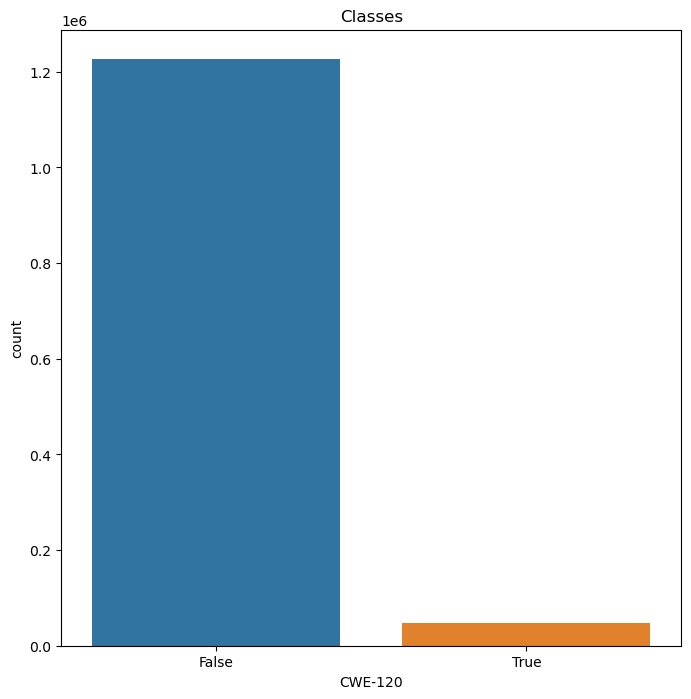

In [22]:
plot_classes(CWE_120_df, 'CWE-120')

We will have to fix this imbalance in the 5 previous datasets we created. This is important, because an imbalanced dataset will hinder the machine learning models and won't allow us to achieve decent classification results.  

To fix this we will apply under-sampling to generate a 50/50 non-vulnerable:vulnerable subset for each vulnerability dataset.

In [18]:
def undersample(dataset, vulnerability_class):
    shuffled_df = dataset.sample(frac=1, random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == 0].sample(n=len(vul_df), random_state=42)
    normalized_df = pd.concat([vul_df, non_vul_df])
    return normalized_df

In [19]:
normalized_CWE_120 = undersample(CWE_120_df, 'CWE-120')
normalized_CWE_119 = undersample(CWE_119_df, 'CWE-119')
normalized_CWE_469 = undersample(CWE_469_df, 'CWE-469')
normalized_CWE_476 = undersample(CWE_476_df, 'CWE-476')
normalized_CWE_OTHERS = undersample(CWE_OTHERS_df, 'CWE-OTHERS')

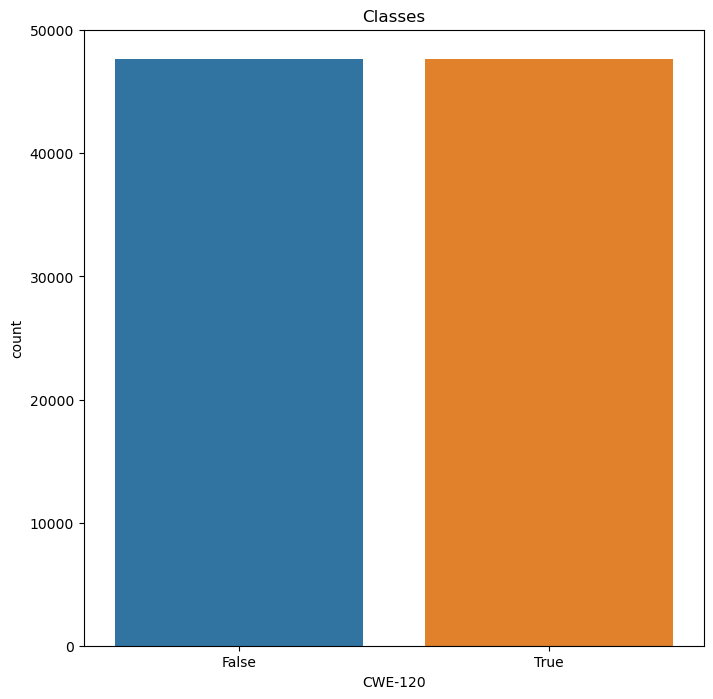

In [23]:
plot_classes(normalized_CWE_120, 'CWE-120')

Now we will prepare the dataset to be processed by clang and to generate the abstract syntax tree

In [26]:
def prepare_for_clang(dataset, vulnerability):
    pass

,level_0,index,code,CWE-120
0,0,1223826,"b'create_NUBspline_1d_z (NUgrid* x_grid, BCtyp...",True
1,1,1079823,b'm92_startup(void)\r\n{\r\n\tunsigned char *R...,True
2,2,916032,"b'chirp_multi_lookup(const char *volume, const...",True
3,3,978421,"b'_parse(VisuConfigFileEntry *entry, gchar **t...",True
4,4,863670,b'CDE_create_path_symlink_dirs() {\n char *p;...,True
...,...,...,...,...
95315,95315,527369,"b""widen_memory_access (rtx memref, enum machin...",False
95316,95316,847469,"b'window_deleted_cb (GtkWidget *widget,\n\...",False
95317,95317,345024,"b'DoCreateItem(SpellEffectIndex eff_idx, uint3...",False
95318,95318,768501,"b'MakeIMAttributeList (Xi18n i18n_core,\n ...",False
